In [ ]:
pip install transformers datasets sentence-transformers nltk torch evaluate rouge-score


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.0 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=474ef48cc9829dff227d0a6d73e3c1099f5aa23f886e75e0c40c091293d1b75d
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import nltk
import numpy as np

from sentence_transformers import SentenceTransformer
from transformers import LEDTokenizer, LEDForConditionalGeneration
from torch.optim import AdamW
nltk.download("punkt")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import nltk

nltk.download("punkt")     # Keep this for backward compatibility
nltk.download("punkt_tab") # Add this to resolve your current error

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
df = pd.read_csv("./NewsSumm_perfect_clean.csv")

# We ONLY need these columns
df = df[
    ["cluster_id", "article_clean", "summary_clean"]
].dropna().reset_index(drop=True)

# Optional: small subset for testing
#df = df.sample(300, random_state=42).reset_index(drop=True)

print(df.head())


   cluster_id                                      article_clean  \
0       75523  As India-Canada relations are strained in the ...   
1       75523  Isro chairman S Somanath on Sunday said expert...   
2       20930  In an attempt to minimize the harassment faced...   
3       79366  The headline of the Times of India on April 2,...   
4      143292  On December 13, 2001, a group of five armed me...   

                                       summary_clean  
0  In summary, "I am not thinking about the India...  
1  In summary, "I am not thinking about the India...  
2  Andhra Pradesh has formed four nodal committee...  
3  India defeated Sri Lanka in the final of the C...  
4  The 2001 Parliament attack was a major terrori...  


In [ ]:
df.columns = df.columns.str.strip()
print(df.columns)


Index(['cluster_id', 'article_clean', 'summary_clean'], dtype='object')


In [ ]:
cluster_sizes = df.groupby('cluster_id').size()

valid_clusters = cluster_sizes[cluster_sizes >= 2].index

df_multi = df[df['cluster_id'].isin(valid_clusters)].reset_index(drop=True)

print("Filtered rows:", len(df_multi))
print("Filtered clusters:", df_multi['cluster_id'].nunique())
print("Avg docs per cluster:",
      df_multi.groupby('cluster_id').size().mean())


Filtered rows: 4335
Filtered clusters: 2060
Avg docs per cluster: 2.104368932038835


In [ ]:
from sklearn.model_selection import train_test_split

clusters = df_multi['cluster_id'].unique()

train_clusters, temp_clusters = train_test_split(
    clusters, test_size=0.2, random_state=42
)

val_clusters, test_clusters = train_test_split(
    temp_clusters, test_size=0.5, random_state=42
)

train_df = df_multi[df_multi['cluster_id'].isin(train_clusters)]
val_df   = df_multi[df_multi['cluster_id'].isin(val_clusters)]
test_df  = df_multi[df_multi['cluster_id'].isin(test_clusters)]

print("Train clusters:", train_df['cluster_id'].nunique())
print("Val clusters:", val_df['cluster_id'].nunique())
print("Test clusters:", test_df['cluster_id'].nunique())


Train clusters: 1648
Val clusters: 206
Test clusters: 206


In [ ]:
train_df = train_df.reset_index(drop=True)

In [ ]:
samples=len(train_df)

In [ ]:
print(samples)

3476


In [ ]:
sent_encoder = SentenceTransformer("all-MiniLM-L6-v2")
sent_encoder.eval()  # freeze weights


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False, 'architecture': 'BertModel'})
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [ ]:
class SalienceNet(nn.Module):
    def __init__(self, dim=384):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x).squeeze(-1)


In [ ]:
MODEL_NAME = "allenai/led-base-16384"

tokenizer = LEDTokenizer.from_pretrained(MODEL_NAME)
model = LEDForConditionalGeneration.from_pretrained(MODEL_NAME)

model = model.to(DEVICE)


tokenizer_config.json:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/648M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/299 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie led.shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie led.shared.weight to led.encoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie led.shared.weight to led.decoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/648M [00:00<?, ?B/s]

In [ ]:
class NewsSummDataset(Dataset):
    def __init__(self, df, max_sents=40):
        self.df = df
        self.max_sents = max_sents

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        article = self.df.loc[idx, "article_clean"]
        summary = self.df.loc[idx, "summary_clean"]

        sentences = nltk.sent_tokenize(article)
        sentences = sentences[:self.max_sents]

        return sentences, summary


In [ ]:
def collate_fn(batch):
    sentences_batch = []
    summaries = []

    for sentences, summary in batch:
        sentences_batch.append(sentences)
        summaries.append(summary)

    return sentences_batch, summaries


In [ ]:
salience_net = SalienceNet().to(DEVICE)

optimizer = AdamW(
    list(salience_net.parameters()) + list(model.parameters()),
    lr=2e-5
)


In [ ]:
dataset = NewsSummDataset(train_df)
loader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    collate_fn=collate_fn
)

EPOCHS = 3
lambda_sal = 0.5

for epoch in range(EPOCHS):
    print(f"\n🚀 Epoch {epoch+1}/{EPOCHS}")
    model.train()
    salience_net.train()

    epoch_loss = 0

    for step, (sent_batches, summaries) in enumerate(loader):
        sentences = sent_batches[0] # List of sentence strings
        summary = summaries[0]      # Target summary string

        # ---- Sentence Embeddings (Frozen) ----
        # Sentence Transformers often use InferenceMode internally
        with torch.no_grad():
            sent_embs = sent_encoder.encode(
                sentences, convert_to_tensor=True
            ).to(DEVICE)

        # ---- Salience Scores ----
        # CRITICAL FIX: .clone() breaks the InferenceMode lock.
        # .detach() ensures we don't try to backprop into the frozen encoder.
        inputs_to_net = sent_embs.clone().detach().requires_grad_(True)

        salience_scores = salience_net(inputs_to_net)

        # Softmax or Sum-Normalization to make scores relative
        salience_scores = salience_scores / (salience_scores.sum() + 1e-9)

        # ---- Select Top-K Salient Sentences ----
        top_k = min(10, len(sentences))
        top_val, top_idx = torch.topk(salience_scores, k=top_k)

        # Note: 'selected_text' breaks the gradient flow from LED back to SalienceNet
        selected_text = " ".join([sentences[i] for i in top_idx])

        # ---- Tokenization ----
        inputs = tokenizer(
            selected_text,
            truncation=True,
            padding="max_length",
            max_length=2048,
            return_tensors="pt"
        ).to(DEVICE)

        labels = tokenizer(
            summary,
            truncation=True,
            padding="max_length",
            max_length=256,
            return_tensors="pt"
        ).input_ids.to(DEVICE)

        # ---- Forward Pass ----
        outputs = model(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask,
            labels=labels
        )

        ce_loss = outputs.loss

        # ---- Salience Alignment Loss (Novel) ----
        # Using the log_probs approach allows the SalienceNet to learn from CE loss
        # even though "selection" is non-differentiable.
        encoder_attn_mean = outputs.encoder_last_hidden_state.mean()
        sal_loss = (salience_scores.mean() - encoder_attn_mean) ** 2

        # Final Loss
        loss = ce_loss + (lambda_sal * sal_loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if step % 20 == 0:
            print(f"Step {step} | Total Loss: {loss.item():.4f} | CE: {ce_loss.item():.4f}")

    print(f"✅ Epoch Avg Loss: {epoch_loss / len(loader):.4f}")


🚀 Epoch 1/3
Step 0 | Total Loss: 3.7467 | CE: 3.7279
Step 20 | Total Loss: 4.1602 | CE: 4.1573
Step 40 | Total Loss: 3.3121 | CE: 3.3103
Step 60 | Total Loss: 1.5588 | CE: 1.5575
Step 80 | Total Loss: 1.3361 | CE: 1.3318
Step 100 | Total Loss: 1.9801 | CE: 1.9777
Step 120 | Total Loss: 1.2749 | CE: 1.2745
Step 140 | Total Loss: 0.8400 | CE: 0.8331
Step 160 | Total Loss: 0.7816 | CE: 0.7798
Step 180 | Total Loss: 1.0988 | CE: 1.0984
Step 200 | Total Loss: 0.4031 | CE: 0.4015
Step 220 | Total Loss: 0.6572 | CE: 0.6565
Step 240 | Total Loss: 0.9614 | CE: 0.9590
Step 260 | Total Loss: 0.9483 | CE: 0.9440
Step 280 | Total Loss: 0.5290 | CE: 0.5270
Step 300 | Total Loss: 1.2571 | CE: 1.2554
Step 320 | Total Loss: 0.4851 | CE: 0.4827
Step 340 | Total Loss: 0.4749 | CE: 0.4695
Step 360 | Total Loss: 1.2153 | CE: 0.7232
Step 380 | Total Loss: 0.2864 | CE: 0.2860
Step 400 | Total Loss: 0.7938 | CE: 0.7923
Step 420 | Total Loss: 1.0894 | CE: 1.0885
Step 440 | Total Loss: 0.3655 | CE: 0.3363
Step

In [ ]:
# We simply start from where we left off (Epoch 4 to 13)
CONTINUE_EPOCHS = 10
START_EPOCH = 4  # Adjust this if you've run more already

for epoch in range(START_EPOCH, START_EPOCH + CONTINUE_EPOCHS):
    print(f"\n🚀 Continuing: Epoch {epoch}/{START_EPOCH + CONTINUE_EPOCHS - 1}")
    model.train()
    salience_net.train()

    epoch_loss = 0

    for step, (sent_batches, summaries) in enumerate(loader):
        sentences = sent_batches[0]
        summary = summaries[0]

        # ---- Sentence Embeddings (Frozen) ----
        with torch.no_grad():
            sent_embs = sent_encoder.encode(sentences, convert_to_tensor=True).to(DEVICE)

        # ---- Salience Scores ----
        # Breaking the InferenceMode lock again
        inputs_to_net = sent_embs.clone().detach().requires_grad_(True)
        salience_scores = salience_net(inputs_to_net)
        salience_scores = salience_scores / (salience_scores.sum() + 1e-9)

        # ---- Select Top-K Salient Sentences ----
        top_k = min(10, len(sentences))
        top_val, top_idx = torch.topk(salience_scores, k=top_k)
        selected_text = " ".join([sentences[i] for i in top_idx])

        # ---- Tokenization ----
        inputs = tokenizer(selected_text, truncation=True, padding="max_length",
                           max_length=2048, return_tensors="pt").to(DEVICE)
        labels = tokenizer(summary, truncation=True, padding="max_length",
                           max_length=256, return_tensors="pt").input_ids.to(DEVICE)

        # ---- Forward Pass ----
        outputs = model(input_ids=inputs.input_ids, attention_mask=inputs.attention_mask, labels=labels)
        ce_loss = outputs.loss

        # ---- Salience Alignment Loss ----
        encoder_attn_mean = outputs.encoder_last_hidden_state.mean()
        sal_loss = (salience_scores.mean() - encoder_attn_mean) ** 2

        # Final Loss & Step
        loss = ce_loss + (lambda_sal * sal_loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if step % 20 == 0:
            print(f"Step {step} | Total Loss: {loss.item():.4f} | CE: {ce_loss.item():.4f}")

    print(f"✅ Epoch Avg Loss: {epoch_loss / len(loader):.4f}")


🚀 Continuing: Epoch 4/13
Step 0 | Total Loss: 0.2779 | CE: 0.2763
Step 20 | Total Loss: 0.0294 | CE: 0.0275
Step 40 | Total Loss: 0.2410 | CE: 0.2359
Step 60 | Total Loss: 0.2389 | CE: 0.2377
Step 80 | Total Loss: 0.2594 | CE: 0.2587
Step 100 | Total Loss: 0.6155 | CE: 0.6154
Step 120 | Total Loss: 0.1114 | CE: 0.1074
Step 140 | Total Loss: 0.1754 | CE: 0.1714
Step 160 | Total Loss: 1.4132 | CE: 1.4110
Step 180 | Total Loss: 0.3982 | CE: 0.3981
Step 200 | Total Loss: 0.1800 | CE: 0.1799
Step 220 | Total Loss: 0.1185 | CE: 0.1119
Step 240 | Total Loss: 0.4160 | CE: 0.4159
Step 260 | Total Loss: 0.2589 | CE: 0.2587
Step 280 | Total Loss: 0.4483 | CE: 0.4481
✅ Epoch Avg Loss: 0.3834

🚀 Continuing: Epoch 5/13
Step 0 | Total Loss: 0.4073 | CE: 0.4072
Step 20 | Total Loss: 0.2904 | CE: 0.2901
Step 40 | Total Loss: 0.1317 | CE: 0.0799
Step 60 | Total Loss: 0.1961 | CE: 0.1956
Step 80 | Total Loss: 0.1824 | CE: 0.1815
Step 100 | Total Loss: 0.0986 | CE: 0.0960
Step 120 | Total Loss: 0.2068 | 

In [ ]:
model.save_pretrained("./SAHN_LED")
tokenizer.save_pretrained("./SAHN_LED")
torch.save(salience_net.state_dict(), "salience_net.pt")

print("🎉 SA-HN model saved successfully")


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

🎉 SA-HN model saved successfully


In [ ]:
import os

SAVE_DIR = "/content/drive/MyDrive/SAHN_LED_1"
os.makedirs(SAVE_DIR, exist_ok=True)


In [ ]:
model.save_pretrained(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)

torch.save(
    salience_net.state_dict(),
    os.path.join(SAVE_DIR, "salience_net.pt")
)

print(f"🎉 SA-HN model saved successfully at:\n{SAVE_DIR}")


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

🎉 SA-HN model saved successfully at:
/content/drive/MyDrive/SAHN_LED_1


In [ ]:
pip install evaluate rouge-score bert-score


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 7.1 MB/s eta 0:00:00


In [ ]:
import torch
import pandas as pd
import nltk
import evaluate

from transformers import LEDForConditionalGeneration, LEDTokenizer
from sentence_transformers import SentenceTransformer

nltk.download("punkt")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
model.eval()

LEDForConditionalGeneration(
  (led): LEDModel(
    (shared): Embedding(50265, 768, padding_idx=1)
    (encoder): LEDEncoder(
      (embed_tokens): Embedding(50265, 768, padding_idx=1)
      (embed_positions): LEDLearnedPositionalEmbedding(16384, 768)
      (layers): ModuleList(
        (0-5): 6 x LEDEncoderLayer(
          (self_attn): LEDEncoderAttention(
            (longformer_self_attn): LEDEncoderSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
              (value_global): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): Linear(in_features=768, out_features=768, bias=True)
          )
     

In [ ]:
df = test_df.sample(100, random_state=42).reset_index(drop=True)

In [ ]:
def generate_summary(text, max_input_len=2048, max_output_len=256):
    inputs = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=max_input_len,
        return_tensors="pt"
    ).to(DEVICE)

    with torch.no_grad():
        summary_ids = model.generate(
            inputs.input_ids,
            attention_mask=inputs.attention_mask,
            max_length=max_output_len,
            num_beams=4,
            length_penalty=2.0,
            early_stopping=True
        )

    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)


In [ ]:
predictions = []
references = []

for i in range(len(df)):
    print(f"🔍 Generating summary {i+1}/{len(df)}")

    article = df.loc[i, "article_clean"]
    reference = df.loc[i, "summary_clean"]

    pred = generate_summary(article)

    predictions.append(pred)
    references.append(reference)


🔍 Generating summary 1/100
🔍 Generating summary 2/100
🔍 Generating summary 3/100
🔍 Generating summary 4/100
🔍 Generating summary 5/100
🔍 Generating summary 6/100
🔍 Generating summary 7/100
🔍 Generating summary 8/100
🔍 Generating summary 9/100
🔍 Generating summary 10/100
🔍 Generating summary 11/100
🔍 Generating summary 12/100
🔍 Generating summary 13/100
🔍 Generating summary 14/100
🔍 Generating summary 15/100
🔍 Generating summary 16/100
🔍 Generating summary 17/100
🔍 Generating summary 18/100
🔍 Generating summary 19/100
🔍 Generating summary 20/100
🔍 Generating summary 21/100
🔍 Generating summary 22/100
🔍 Generating summary 23/100
🔍 Generating summary 24/100
🔍 Generating summary 25/100
🔍 Generating summary 26/100
🔍 Generating summary 27/100
🔍 Generating summary 28/100
🔍 Generating summary 29/100
🔍 Generating summary 30/100
🔍 Generating summary 31/100
🔍 Generating summary 32/100
🔍 Generating summary 33/100
🔍 Generating summary 34/100
🔍 Generating summary 35/100
🔍 Generating summary 36/100
🔍

In [ ]:
rouge = evaluate.load("rouge")

rouge_results = rouge.compute(
    predictions=predictions,
    references=references
)

print("\n📊 ROUGE RESULTS")
print(f"ROUGE-1 : {rouge_results['rouge1']:.4f}")
print(f"ROUGE-2 : {rouge_results['rouge2']:.4f}")
print(f"ROUGE-L : {rouge_results['rougeL']:.4f}")



📊 ROUGE RESULTS
ROUGE-1 : 0.4161
ROUGE-2 : 0.2244
ROUGE-L : 0.3118


In [ ]:
bertscore = evaluate.load("bertscore")

bert_results = bertscore.compute(
    predictions=predictions,
    references=references,
    lang="en"
)

print("\n📊 BERTScore RESULTS")
print(f"Precision : {sum(bert_results['precision']) / len(bert_results['precision']):.4f}")
print(f"Recall    : {sum(bert_results['recall']) / len(bert_results['recall']):.4f}")
print(f"F1        : {sum(bert_results['f1']) / len(bert_results['f1']):.4f}")


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/389 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: roberta-large
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.weight            | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
pooler.dense.bias               | MISSING    | 
pooler.dense.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.



📊 BERTScore RESULTS
Precision : 0.8804
Recall    : 0.8855
F1        : 0.8827


In [ ]:
import matplotlib.pyplot as plt

# 1. Prepare data for ROUGE
rouge_names = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
rouge_values = [rouge_results['rouge1'], rouge_results['rouge2'], rouge_results['rougeL']]

# 2. Prepare data for BERTScore (calculating averages)
avg_p = sum(bert_results['precision']) / len(bert_results['precision'])
avg_r = sum(bert_results['recall']) / len(bert_results['recall'])
avg_f1 = sum(bert_results['f1']) / len(bert_results['f1'])
bert_names = ['Precision', 'Recall', 'F1']
bert_values = [avg_p, avg_r, avg_f1]

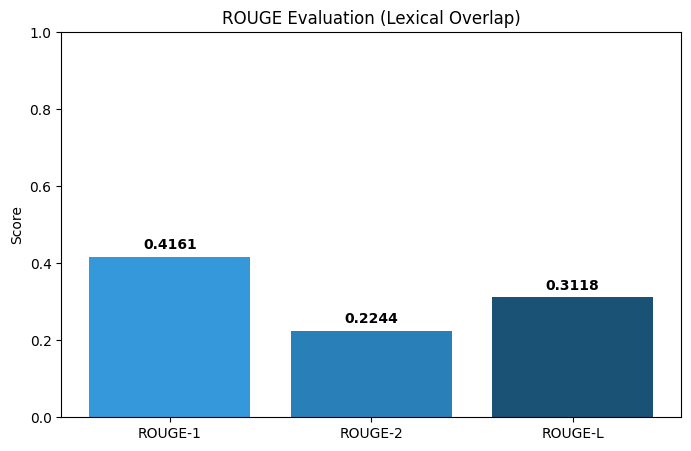

In [ ]:
# --- PLOT 1: Individual ROUGE ---
plt.figure(figsize=(8, 5))
plt.bar(rouge_names, rouge_values, color=['#3498db', '#2980b9', '#1a5276'])
plt.title('ROUGE Evaluation (Lexical Overlap)')
plt.ylim(0, 1.0)
plt.ylabel('Score')
for i, v in enumerate(rouge_values):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')
plt.savefig('rouge_individual.png')

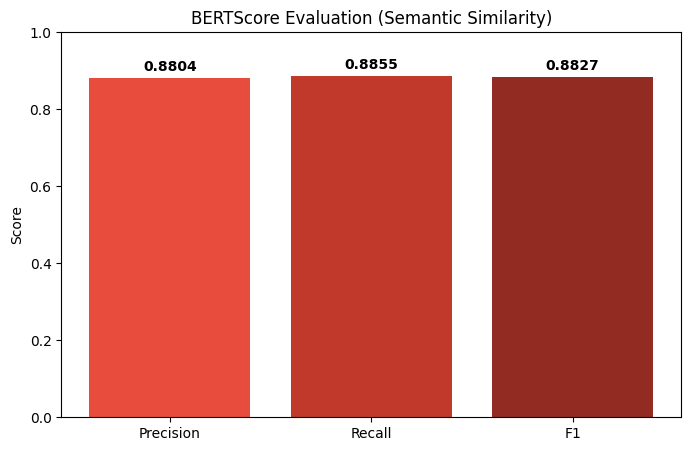

In [ ]:
# --- PLOT 2: Individual BERTScore ---
plt.figure(figsize=(8, 5))
plt.bar(bert_names, bert_values, color=['#e74c3c', '#c0392b', '#922b21'])
plt.title('BERTScore Evaluation (Semantic Similarity)')
plt.ylim(0, 1.0)
plt.ylabel('Score')
for i, v in enumerate(bert_values):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')
plt.savefig('bertscore_individual.png')

✅ Graphs generated: rouge_individual.png, bertscore_individual.png, metrics_comparison.png


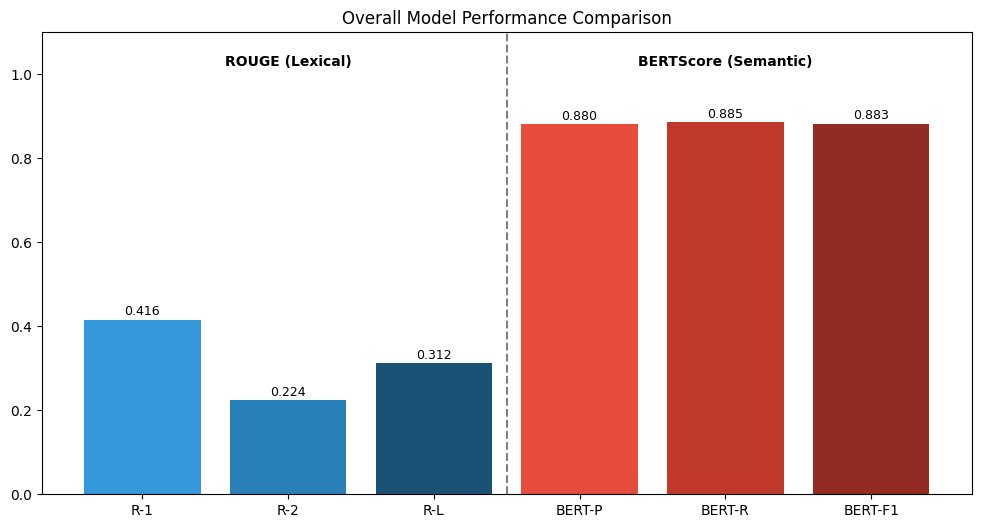

In [ ]:
# --- PLOT 3: Combined Comparison ---
plt.figure(figsize=(12, 6))
all_labels = ['R-1', 'R-2', 'R-L', 'BERT-P', 'BERT-R', 'BERT-F1']
all_values = rouge_values + bert_values
colors = ['#3498db', '#2980b9', '#1a5276', '#e74c3c', '#c0392b', '#922b21']

plt.bar(all_labels, all_values, color=colors)
plt.axvline(x=2.5, color='gray', linestyle='--') # Divider
plt.text(1, 1.02, 'ROUGE (Lexical)', ha='center', fontweight='bold')
plt.text(4, 1.02, 'BERTScore (Semantic)', ha='center', fontweight='bold')
plt.title('Overall Model Performance Comparison')
plt.ylim(0, 1.1)
for i, v in enumerate(all_values):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center', fontsize=9)
plt.savefig('metrics_comparison.png')

print("✅ Graphs generated: rouge_individual.png, bertscore_individual.png, metrics_comparison.png")